In [1]:
"""
Life Cycle models
Problem Set 4 Quantitative Macro
Joe Emmens
"""

'\nLife Cycle models\nProblem Set 4 Quantitative Macro\nJoe Emmens\n'

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize, fminbound
import quantecon as qe
import matplotlib.patches as mpatches

In [3]:
os.chdir("C:/Users/Joe's PC/Documents/IDEA Masters/Second Year/First Semester/Quantitative Macro/Problem Sets/PS4")

In [4]:
sigma = 2
r = 0.04
q = 1 / (1 + r)
rho = 0.06
w = 1.5
beta = 1 / (1+ rho)
c_bar = 10

"income process given CRRA and natural borrowing limit. Agents CAN borrow"
N = 2
sigma_y = 0.5
y_min = 1 - sigma_y
y_max = 1 + sigma_y
y_grid = np.linspace(y_min, y_max, N)

A_natural = -1*(((1+r) / r) * y_min)
A_no = 0

a_max = 4
a_num = 100

gamma = 0.95

trans_mat = np.array([[(1+gamma)/2, (1-gamma)/2],[(1-gamma)/2, (1+gamma)/2]])


@np.vectorize
def CRRA(y, a, a_prime, w, q, sigma):
    """ CRRA Utility function"""

    c = w*y + a - q*a_prime
    if c > 0:

        if sigma > 1:
            u = ((c)**(1 - sigma)) / (1 - sigma)

        elif sigma == 1:
            u = np.log(c)
    else:
        u = -1000000
    return u

@np.vectorize
def cons(y, a, a_prime, w, q):
    """ Consumption function"""

    return w*y + a - q*a_prime

@np.vectorize
def quadratic(y, a, a_prime, w, q, c_bar):

    c = w*y + a - q*a_prime
    if c > 0:
        u = -(1/2) * (c - c_bar)**2
    else:
        u = -500
    return u



In [20]:
def LifeCycleFunctions(utility, Borrowing=True, r=0.04, sigma=2, rho=0.06, w=4,
               N=2, sigma_y=0, gamma=0, a_max=40, a_num=100, c_bar=10, fig_name="Missing"):

    beta = 1 / (1 + rho)
    y_min = 1 - sigma_y
    y_max = 1 + sigma_y
    y_grid = np.linspace(y_min, y_max, N)

    trans_mat = np.array([[(1+gamma)/2, (1-gamma)/2],[(1-gamma)/2, (1+gamma)/2]])

    M = np.zeros((N, a_num, a_num))

    if Borrowing == True:

        Abar = -1*(((1+r) / r) * y_min)

    elif Borrowing == False:
        Abar = 0

    else:
        print("Borrowing must either be True or False")

    a_grid = np.linspace(Abar, a_max, a_num)

    for (idy, y) in enumerate(y_grid):
        for (ida, a) in enumerate(a_grid):
            for (ida_p, a_prime) in enumerate(a_grid):

                if utility == CRRA:

                    M[idy, ida, ida_p] = utility(y, a, a_prime, w=w, q=q, sigma=sigma)

                elif utility == quadratic:

                    M[idy, ida, ida_p] = utility(y, a, a_prime, w=w, q=q, c_bar=c_bar)


    X = np.ones(np.shape(M))*-5000

    T = 45
    vals = []
    policy_rules_a = []
    policy_rules_c = []
    for t in reversed(range(T)):

        if t == 44:

            V = M.max(2)
            vals.append(V)

        else:
            V_old = vals[-1]
            for y in range(N):
                for a in range(a_num):

                    V_old = np.dot(trans_mat, V_old)

                    X[y][:, a] = M[y][:, a] + beta*V_old[y][a]

            V = X.max(2)
            vals.append(V)


        ga = np.zeros_like(V)
        gc = np.zeros_like(V)
        policy_rules_a.append(ga)
        policy_rules_c.append(gc)

        a_policy = np.argmax(X, axis=2)
        for (idy,y) in enumerate(y_grid):
            for a in range(a_num):

                ga[idy, a] = a_grid[a_policy[idy, a]]
        policy_rules_a.append(ga)

        for (idy, y) in enumerate(y_grid):
            for a in range(a_num):

                gc[idy, a] = w*y + a - q*ga[idy, a]
        policy_rules_c.append(gc)


    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, facecolor="w", figsize=(11, 6))
    fig.suptitle("Consumption and Saving Functions", fontsize=20)

    ax1.plot(a_grid, policy_rules_c[4][0, :], label=r"$y = y_{min}$, t = 5", c="firebrick", dashes=[6,2])
    ax1.plot(a_grid, policy_rules_c[4][1, :], label=r"$y = y_{max}$, t = 5", c="darkslategray", dashes=[2, 2, 10 ,2])
    ax1.plot(a_grid, policy_rules_c[39][0, :], label=r"$y = y_{min}$, t = 40", c="firebrick")
    ax1.plot(a_grid, policy_rules_c[39][1, :], label=r"$y = y_{max}$,t = 40", c="darkslategray")
    ax1.set_title("Consumption Function", fontsize=14)
    ax1.set_xlabel("a")
    ax1.legend(fontsize=14)

    ax2.plot(a_grid, policy_rules_a[4][0, :], label=r"$y = y_{min}$, t = 5", c="firebrick", dashes=[6,2])
    ax2.plot(a_grid, policy_rules_a[4][1, :], label=r"$y = y_{max}$, t = 5", c="darkslategray", dashes=[2, 2, 10 ,2])
    ax2.plot(a_grid, policy_rules_a[39][0, :], label=r"$y = y_{min}$, t = 40", c="firebrick")
    ax2.plot(a_grid, policy_rules_a[39][1, :], label=r"$y = y_{max}$,t = 40", c="darkslategray")
    ax2.set_xlabel("a")
    ax2.set_title("Saving Function", fontsize=14)
    fig.savefig(fig_name)

    ax2.legend(fontsize=14)

    return policy_rules_a, policy_rules_c, a_grid

In [13]:

def ConsPath(a_grid, T=45, specs="", file_name="Missing"):
    np.random.seed(1)
    y_shock = np.random.choice([0, 1], 1)

    a_0 = a_grid[0]
    ida = np.where(a_grid == a_0)[0]
    c_0 = policy_rules_c[0][y_shock, ida]

    y_shocks = [y_shock]

    cons_path = [c_0]
    asset_path = [a_0]

    for t in range(1, T):

        y_shock = np.random.choice([0, 1], 1)
        ida = np.where(a_grid == asset_path[-1])[0]

        a_prime = policy_rules_a[t][y_shock, ida]
        c = policy_rules_c[t][y_shock, ida]

        y_shocks.append(y_shock)

        asset_path.append(a_prime)
        cons_path.append(c)

    time = np.arange(T)
    fig, ax = plt.subplots(facecolor="w")
    ax.plot(time, cons_path, label = "Consumption Path", c="firebrick")
    ax.plot(time, asset_path, label = "Asset Path", c="darkslategray")

    ax2 = ax.twinx()
    ax2.scatter(time, y_shocks, label="y shocks", c="grey", alpha=0.5)
    ax2.axes.yaxis.set_ticks([])

    scatter_legend = mpatches.Patch(color='firebrick', label='Consumption')
    scatter_cons = mpatches.Patch(color='darkslategray', label='Asset')
    scatter_ass = mpatches.Patch(color='grey', label='y shocks')

    plt.legend(handles=[scatter_legend, scatter_cons, scatter_ass], loc=0)

    plt.title(f"{specs}", fontsize=14)
    plt.xlabel("Time")
    plt.tight_layout()

    fig.savefig(f"{file_name}")


    return np.array(cons_path), np.array(asset_path)




C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-13-ca7c2c230cf3>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(cons_path), np.array(asset_path)


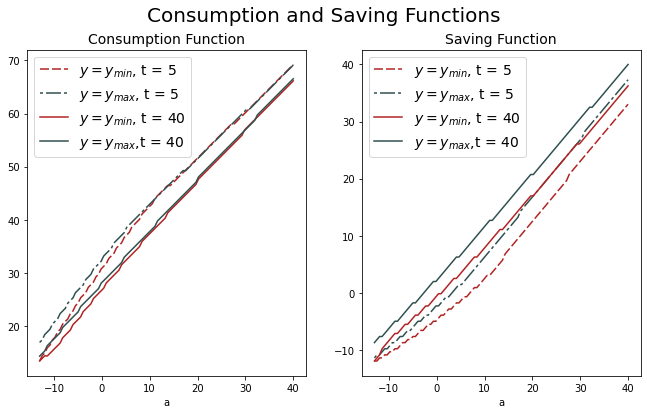

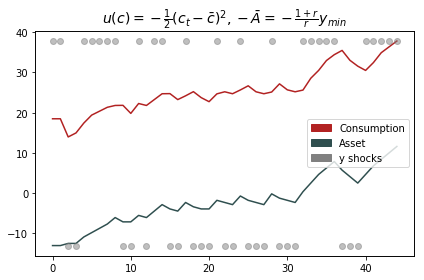

In [36]:
os.chdir("C:/Users/Joe's PC/Documents/IDEA Masters/Second Year/First Semester/Quantitative Macro/Problem Sets/PS4/Life cycle functions/Quad")

policy_rules_a, policy_rules_c, a_grid = LifeCycleFunctions(quadratic, Borrowing = True, sigma_y=0.5, gamma=0.95,
                                                            fig_name="Quad Natural A, sigma=2, sigma_y=05, gamma = 095")


consumption, ass = ConsPath(a_grid, specs=r"$u(c)= -\frac{1}{2}(c_t - \bar{c})^2, -\bar{A} = -\frac{1+r}{r}y_{min}$",
                     file_name= "Quad, Natural Borrowing, sigma=2, sigma_y=05, gamma=095")

In [8]:
"Specifications"

r"$u(c)= -\frac{1}{2}(c_t - \bar{c})^2, -\bar{A} = -\frac{1+r}{r}y_{min}$"
r"$u(c)= \frac{c_t^{1-\sigma} - 1}{1-\sigma}, -\bar{A} = -\frac{1+r}{r}y_{min}$"


'$u(c)= \\frac{c_t^{1-\\sigma} - 1}{1-\\sigma}, -\\bar{A} = -\\frac{1+r}{r}y_{min}$'